
# Unit 2 Notebook — Correlation & Granger Causality

*A practical walkthrough with simulations you can tweak.*  
**Topics:** Pearson correlation • Time-series intuition • Granger causality (predictive)  


In [1]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Statsmodels for Granger causality
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

np.random.seed(42)
pd.options.display.precision = 4



## 1) Pearson Correlation — intuition first

**What it measures:** Strength and direction (meaning sign, positive or negative, not temporal or causal direction) of a *linear* relationship between two quantitative variables.  
**Range:** -1 (perfect negative) to +1 (perfect positive); 0 means *no linear* relationship.

We'll simulate two scenarios:
1. **Linear relationship**: clear positive correlation.
2. **Curvy relationship**: strong association but *Pearson misses it* (hint: it's not linear).

### Pearson loves straight lines. Curves? Not so much.


Pearson r (linear case): 0.952


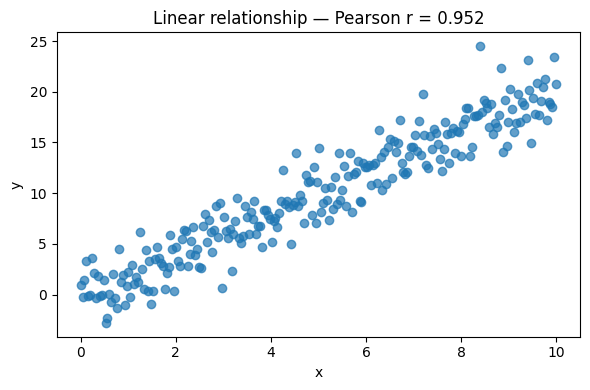

In [2]:
# --- Scenario 1: Linear relationship ---
n = 250
x = np.linspace(0, 10, n)
y = 2.0 * x + np.random.normal(0, 2, size=n)

r_linear = np.corrcoef(x, y)[0,1]
print(f"Pearson r (linear case): {r_linear:.3f}")

plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.7)
plt.title(f"Linear relationship — Pearson r = {r_linear:.3f}")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()


Pearson r (nonlinear case): -0.027  <-- low, despite obvious association


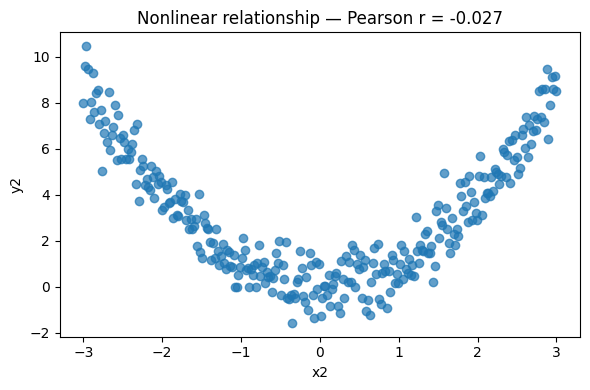

In [3]:
# --- Scenario 2: Nonlinear relationship (Pearson underestimates) ---
n = 300
x2 = np.linspace(-3, 3, n)
y2 = x2**2 + np.random.normal(0, 0.8, size=n)

r_nonlinear = np.corrcoef(x2, y2)[0,1]
print(f"Pearson r (nonlinear case): {r_nonlinear:.3f}  <-- low, despite obvious association")

plt.figure(figsize=(6,4))
plt.scatter(x2, y2, alpha=0.7)
plt.title(f"Nonlinear relationship — Pearson r = {r_nonlinear:.3f}")
plt.xlabel("x2")
plt.ylabel("y2")
plt.tight_layout()
plt.show()

# Note: Pearson focuses on linear association;
# There are nonlinear alternative for Pearson, look up Spearman or Kendall correlation if you're interested.


## 2) From correlation to *temporal* predictiveness

Correlation is **atemporal**: it ignores *order*.  
Time series let us ask a new question:

> **Does the past of X help predict the future of Y (beyond Y's own past)?**

That's the idea behind **Granger causality**.



### 2.1 Simulating a simple causal story (X → Y)

We'll create a system where **X drives Y with a lag**:
- Xₜ = 0.7·Xₜ₋₁ + noise
- Yₜ = 0.6·Yₜ₋₁ + **0.8·Xₜ₋₁** + noise

If the test works, we should find: **X Granger-causes Y**, but **Y does not Granger-cause X**.


In [4]:

def simulate_var1(n=400, burn=50, ax=0.7, ay=0.6, b_xy=0.8, b_yx=0.0, sx=1.0, sy=1.0):
    X = np.zeros(n + burn)
    Y = np.zeros(n + burn)
    for t in range(1, n + burn):
        X[t] = ax * X[t-1] + np.random.normal(scale=sx)
        Y[t] = ay * Y[t-1] + b_xy * X[t-1] + np.random.normal(scale=sy)
    return X[burn:], Y[burn:]

X, Y = simulate_var1()
df = pd.DataFrame({"X": X, "Y": Y})
df.head()


,X,Y
0,-2.6644,-3.8310
1,-0.0161,-3.3035
2,-0.2802,-3.1015
3,2.3773,-2.0258
4,1.6780,0.6622


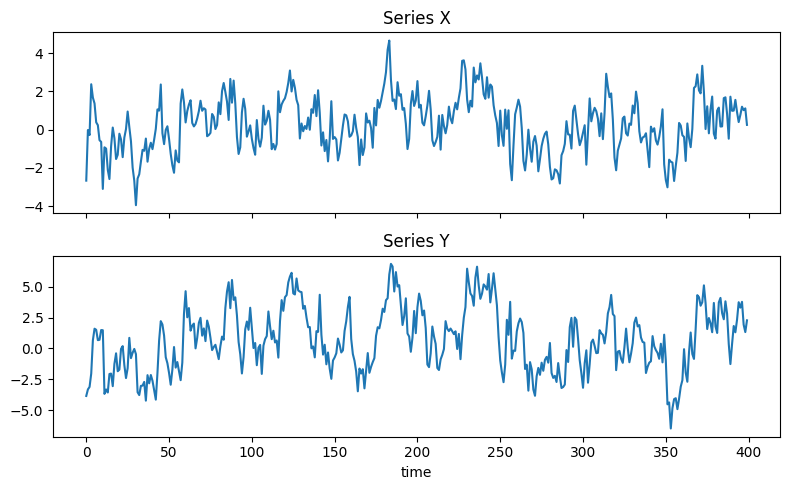

In [5]:
# Quick look at what the series look like
fig, axes = plt.subplots(2, 1, figsize=(8,5), sharex=True)
axes[0].plot(df["X"])
axes[0].set_title("Series X")
axes[1].plot(df["Y"])
axes[1].set_title("Series Y")
axes[1].set_xlabel("time")
plt.tight_layout()
plt.show()


In [6]:
# Granger test: Does X (lags) help predict Y?
# The function expects a 2D array with [Y, X] columns in this order.
maxlag = 3
print("H0: 'X does NOT Granger-cause Y'")
res_xy = grangercausalitytests(df[["Y","X"]], maxlag=maxlag, verbose=False)
for lag in range(1, maxlag+1):
    pval = res_xy[lag][0]["ssr_ftest"][1]
    print(f"lag {lag}: p = {pval:.4f}")

# If the p values are small (e.g., < 0.05), we reject H0 and conclude that X Granger-causes Y.

H0: 'X does NOT Granger-cause Y'
lag 1: p = 0.0000
lag 2: p = 0.0000
lag 3: p = 0.0000


/Users/parnaz/Documents/Github/inference-and-causality-week2/.venv/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [7]:

# Reverse direction: Does Y Granger-cause X? (should NOT, in our simulation)
print("H0: 'Y does NOT Granger-cause X'")
res_yx = grangercausalitytests(df[["X","Y"]], maxlag=maxlag, verbose=False)
for lag in range(1, maxlag+1):
    pval = res_yx[lag][0]["ssr_ftest"][1]
    print(f"lag {lag}: p = {pval:.4f}")

# If the p values are small (e.g., < 0.05), we reject H0 and conclude that Y Granger-causes X.

H0: 'Y does NOT Granger-cause X'
lag 1: p = 0.0817
lag 2: p = 0.0241
lag 3: p = 0.0235


/Users/parnaz/Documents/Github/inference-and-causality-week2/.venv/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



### 2.2 Caveats you must remember

- **Predictive ≠ causal mechanism.** Granger tests predictiveness in time, not true cause.  
- **Omitted common causes** can fool the test.  
- **Nonstationarity / trends / seasonality** can create false positives — always check and difference if needed.  
- **Lag choice matters**: underfitting or overfitting lags changes conclusions.  



## 3) Mini Exercise — Build, test, explain

1. **Simulate your own pair of time series** where **Y depends on X with a lag of 2**.  
   - Hint: make `Y[t] = 0.5*Y[t-1] + 0.9*X[t-2] + noise`.
2. **Run Granger tests** for lags 1..4 in **both directions**.  
3. **Explain** in 2–4 sentences why the *reverse* direction should (ideally) not be significant.
4. **(Bonus)** Add a seasonal driver to both and observe how it changes results; then remove it by differencing.

> Deliverable: a short markdown cell with your explanation + the printed p-values.


In [15]:
# Your answer goes here.
def simulate_var1(n=400, burn=50, ax=0.7, ay=0.5, b_xy=0.9, b_yx=0.0, sx=1.0, sy=1.0):
    X = np.zeros(n + burn)
    Y = np.zeros(n + burn)
    for t in range(1, n + burn):
        X[t] = ax * X[t-1] + np.random.normal(scale=sx)
        Y[t] = ay * Y[t-1] + b_xy * X[t-2] + np.random.normal(scale=sy)
    return X[burn:], Y[burn:]

X, Y = simulate_var1()
df = pd.DataFrame({"X": X, "Y": Y})
maxlag = 2
print("H0: 'X does NOT Granger-cause Y'")
res_xy = grangercausalitytests(df[["Y","X"]], maxlag=maxlag, verbose=False)
for lag in range(1, maxlag+1):
    pval = res_xy[lag][0]["ssr_ftest"][1]
    print(f"lag {lag}: p = {pval:.4f}")
print("H0: 'Y does NOT Granger-cause X'")
res_yx = grangercausalitytests(df[["X","Y"]], maxlag=maxlag, verbose=False)
for lag in range(1, maxlag+1):
    pval = res_yx[lag][0]["ssr_ftest"][1]
    print(f"lag {lag}: p = {pval:.4f}")

H0: 'X does NOT Granger-cause Y'
lag 1: p = 0.0000
lag 2: p = 0.0000
H0: 'Y does NOT Granger-cause X'
lag 1: p = 0.8413
lag 2: p = 0.1990


/Users/parnaz/Documents/Github/inference-and-causality-week2/.venv/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/parnaz/Documents/Github/inference-and-causality-week2/.venv/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


The p-values in the reverse test are high so it is not significant, which means that Y does not help predict X.


---

### Wrap-up

- **Pearson**: quick check for linear association.  
- **Granger**: tests whether the past of one series improves prediction of another.  
- **Beware** trends/seasonality and omitted variables might influence your numbers.
  
